# Tarea 2
## Importación de módulos

In [9]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from IPython.display import display
import matplotlib.pyplot as plt

## Clase del problema

In [10]:
# Se crea una clase para definir el problema ya que pymoo funciona con POO. 
# Se usa un problema ElementWise para que se califique cada solución y no se haga en conjuntos.
class MyProblem(ElementwiseProblem):
    # constructor de la clase, recibe la cantidad de genes del cromosoma (n_var), 
    # la cantidad de funciones objetivo (n_obj), 
    # límite inferior de los genes (xl) y el límite superior (xu)
    def __init__(self):
        super().__init__(n_var=3,
                        n_obj=2,
                        xl=0,
                        xu=200)
    # Esta función guarda la definición del cromosoma y las funciones objetivo
    def _evaluate(self, x, out, *args, **kwargs):
        
        # Cantidad de tornos
        T = x[0]
        # Cantidad de fresadoras
        F = x[1]
        # Cantidad de multiproposito
        M = x[2]
        
        #Se definen las penalizaciones por el sobrepaso de material

        #Cableado
        penCab = 280 - (2*T+F+5*M)
        #Motores
        penM  = 120 - (6*T+3*F+12*M)
        #Carcasas
        penCar = 670 - (2*T+8*F+4*M)
        #Actuadores
        penA = 250 - (2*T+6*F+6*M)
        
        #Vector con las penalizaciones
        penalizaciones = [penCab, penM, penCar, penA] 
        
        pen = 0
        
        #Sumatoria de penalizaciones y se filtran aquellas que sean números naturales o cero.
        for i in range(4):
            if penalizaciones[i] < 0:
                pen = pen + penalizaciones[i]
        
        #Funcion objetivo de la ganancia
        f1 = -(4*T+8*F+12*M)+15*pen**2 
        #Funcion objetivo de la producción
        f2 = (abs(T-F)+abs(T-M)+abs(F-M))**3
        
        out["F"] = [f1, f2]
        
problem = MyProblem()    

## Inicialización del algoritmo

In [11]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.crossover.pntx import SinglePointCrossover

# Se utiliza el algoritmo NSGA2, para la selección de individuos para el cruce se usa por defecto un algoritmo de torneo binario
# La población es de 200
algorithm = NSGA2(pop_size=200, 
                # Se escogen solo números enteros para los genes
                sampling=IntegerRandomSampling(),
                # Se usa como algoritmo de cruce un punto variable con un corte.
                crossover=SinglePointCrossover(),
                # La mutación es un algoritmo de mutación polinómica con una probabilidd de 5%.
                mutation=PM(prob=0.05, vtype=float, repair=RoundingRepair()),
                # Se eliminan las soluciones dobles.
                eliminate_duplicates = True)

## Criterio de parada

In [12]:
from pymoo.termination import get_termination
# El agoritmo para cuando ya ha corrido 100 generaciones
termination = get_termination("n_gen", 100)

## Optimización y Normalización

In [13]:
from pymoo.optimize import minimize
#Se utiliza una funcion de minimización para minimizar las funciones objetivo
res = minimize(problem,
            algorithm,
            termination,
            save_history=True,
            verbose=True)

# Vector que guarda la mejor solución por generación
X = res.X
# Se cambia el signo de los resultados de las funciones para que la gráfica quede con los datos reales
res.F = res.F*-1
# Vector que guarda el frente de pareto
F = res.F

#Normalización del resultado

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
#Normalización del frente de Pareto, con una normalización min-max
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      4 |             - |             -
     2 |      400 |      7 |  0.2984962406 |         nadir
     3 |      600 |      6 |  0.5530579477 |         nadir
     4 |      800 |      6 |  0.0668987074 |             f
     5 |     1000 |      6 |  0.0550902392 |             f
     6 |     1200 |      3 |  5.755556E+01 |         nadir
     7 |     1400 |      3 |  0.0096153846 |         ideal
     8 |     1600 |      3 |  0.000000E+00 |             f
     9 |     1800 |      4 |  0.0402276464 |             f
    10 |     2000 |      6 |  0.8222222222 |         nadir
    11 |     2200 |      8 |  0.6153846154 |         nadir
    12 |     2400 |      9 |  9.8609961573 |         nadir
    13 |     2600 |     10 |  0.8885961735 |         nadir
    14 |     2800 |     10 |  0.0132823041 |             f
    15 |     3000 |     11 |  0.7009086709 |         nadir
    16 |     3200 |     11 |  0.000000E+00 |            

## Convergencia de Cada Objetivo

In [14]:
from pymoo.indicators.hv import HV

# Se toma una muestra del frente cada 7 soluciones
A = nF[::7] 
# Se pone el punto de referencia (un punto muy malo) como -120 para f1 y 6000 para f2 
ref_point = np.array([1.2, 1.2])
# Se calcula el indicador del hipervolumen
ind = HV(ref_point=ref_point)
# Se imprime el indicador con cinco decimales
print("HV", '%.5f' % ind(A)) 


HV 0.43273


## Visualización de Resultados y Mejor resultado por medio de Compromise Programing 

Best regarding ASF: Point 
i = 8
F = [    248. -125000.]
X = [ 1 26  3]


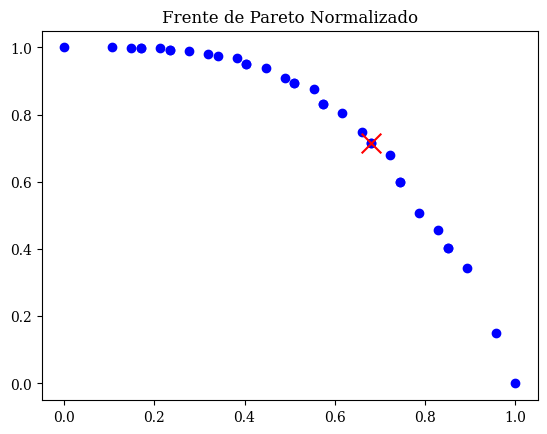

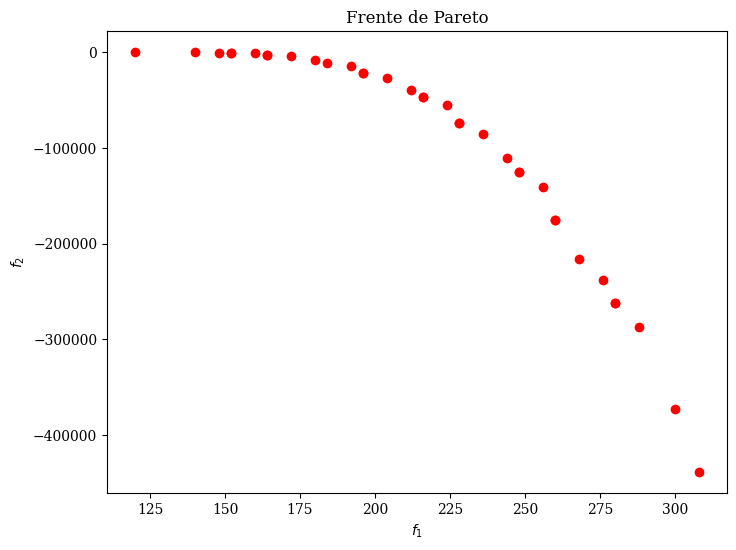

In [19]:

from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.asf import ASF

#Peso que determina la importacia de las soluciones
weights = np.array([0.5, 0.5])
#????
decomp = ASF()
#????
i = decomp.do(nF, 1/weights).argmin()

print("Best regarding ASF: Point \ni = %s\nF = %s\nX = %s" % (i, F[i], X[i]))

# Funcion que genera ambas gráficas del frente de Pareto.
def ParetoFrontGraph(pf, title, color, nF, i, x):
    # Si el parámetro x es verdadero se imprime la gráfica con el frente normalizado y la "mejor" solución
    if x is True:
        plt.scatter(nF[:, 0], nF[:, 1], color=color)
        plt.scatter(nF[i, 0], nF[i, 1], marker="x", color='red', s=200)
        plt.title(title)
        plt.show()
    # Si no se imprime el frente normal.
    else:
        plot = Scatter(title=title)
        plot.add(pf, color=color)
        return plot
    
ParetoFrontGraph(F, "Frente de Pareto Normalizado", "blue", nF, i, True)
ParetoFrontGraph(F, "Frente de Pareto", "red", nF, i, False).show()

# Referencias

#### https://pymoo.org/getting_started/index.html
#### https://pymoo.org/customization/discrete.html
#### https://pymoo.org/interface/problem.html
#### https://ai.vub.ac.be/sites/default/files/EMO_2013_1.pdf
#### https://pymoo.org/misc/indicators.html